# Gapped k-mer Support Vector Machine (gkSVM) Evaluation

**Authorship:**
Adam Klie, *09/26/2021*
***
**Description:**
Notebook for the interpretation of gkSVM model predictions based on gkmexplain
***
**TODOs:**
 - <font color='red'> Set-up notebook </font>
 - <font color='red'> Load test dataset + predictions + other needed data </font>
 - <font color='red'> For each sequence </font>
***

# Set-up

## Imports

In [1]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
import tqdm

# For stats
from scipy import stats

# For ml
from sklearn.metrics import confusion_matrix
import vizsequence
from vizsequence import viz_sequence

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Local Paths
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils
import otx_enhancer_utils

# Plotting params
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

## Define parameters of the notebook

In [2]:
# Define params for dataset loading
ACTIVE_LOW = 0.09  # The activity below which to define inactive enhancers
ACTIVE_HIGH = 0.4  # The activity above which to define active enhancers
PREPROCESS = "{}-{}".format(ACTIVE_LOW, ACTIVE_HIGH)  # String defining the preprocessing for saving
FEATURES = "fasta"  # What features to use to train the model
LABELS = "binary"
HYPERPARAM = "final-selected"
OUTDIR = "../gkSVM/Result_{0}_{1}_gkSVM-clf_{2}".format(PREPROCESS, FEATURES, HYPERPARAM)

# Test Dataset

## Load data

In [3]:
# Define the dataset to grab data from
dataset = "2021_OLS_Exact_Syntax_Match"

# Define the important files for this dataset
dataframe_f = "../data/{0}/{0}.tsv".format(dataset)
scores_f = os.path.join(OUTDIR, "{}.predict.txt".format(dataset))

print("Loading data for {}\n\tdataframe: {}\n\tscores: {}".format(dataset, dataframe_f, scores_f))

# Load the dataframe
test_dataframe = pd.read_csv(dataframe_f, sep="\t")

# Load the scores for these sequences
test_scores = pd.read_csv(scores_f, delim_whitespace=True, header=None, names=["NAME", "GKSVM_SCORE"])
test_scores["GKSVM_PREDS"] = (test_scores["GKSVM_SCORE"] >= 0).astype(int)

# Merge these dataframes and add the results of the classification
test_clf = pd.merge(test_dataframe, test_scores, on="NAME")
test_clf["GKSVM_CLF"] = ["-".join(list(value)) for value in test_clf[["FXN_LABEL", "GKSVM_PREDS"]].values.astype(str)]
test_clf["GKSVM_CLF"] = test_clf["GKSVM_CLF"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test_clf.head()

Loading data for 2021_OLS_Exact_Syntax_Match
	dataframe: ../data/2021_OLS_Exact_Syntax_Match/2021_OLS_Exact_Syntax_Match.tsv
	scores: ../gkSVM/Result_0.09-0.4_fasta_gkSVM-clf_final-selected/2021_OLS_Exact_Syntax_Match.predict.txt


,NAME,SEQ,FXN_LABEL,FXN_DESCRIPTION,TILE,SEQ_LEN,GKSVM_SCORE,GKSVM_PREDS,GKSVM_CLF
0,EM.Ci1,CCTATCTTAGATATTGAACAATTTCCTTTTCGAAAACTTCCGTTAG...,1,WT Control,Full,53,1.607850,1,TP
1,EM.Dr1,TTTTCCAGTTGCGATATTTTTGGTATTTATCTTCAGGAAATCACTA...,1,b-lineage only,Full,61,-0.009901,0,FN
2,EM.Ggd1,CAGATATGGTACCTTGCGATATTATAGTCAGGAAGCATGGAAAGAA...,0,No expr,Full,53,0.045951,1,FP
3,EM.Mm6,AATATCTGTTTATCACCAAAGGAAGTCAAGACAGGAACTATGCAGA...,0,No expr,Full,58,0.110725,1,FP
4,EM.Hs9,CATATCTACAAAGGAAGTAACCATACGATAGTATAAAATGATAGAA...,0,No expr,Full,65,0.052221,1,FP


## Confusion Matrix

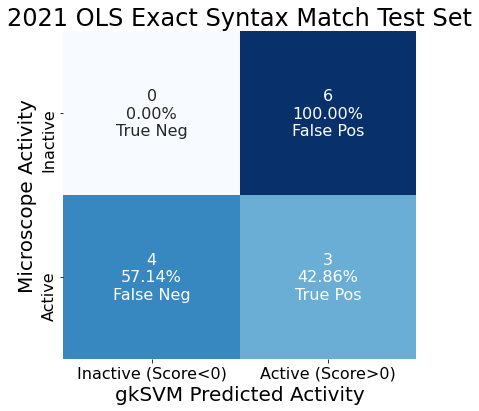

In [4]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

rc = {"font.size": 16}
with plt.rc_context(rc):
    cf_names = ["True Neg","False Pos", "False Neg","True Pos"]
    cf_mtx = confusion_matrix(test_clf["FXN_LABEL"], test_clf["GKSVM_PREDS"])
    cf_pcts = ["{0:.2%}".format(value) for value in (cf_mtx/cf_mtx.sum(axis=1)[:,None]).flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(cf_mtx.flatten(),cf_pcts, cf_names)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_mtx, annot=labels, fmt='s', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('gkSVM Predicted Activity', fontsize=20)
    ax.set_ylabel('Microscope Activity', fontsize=20)
    ax.set_title('{} Test Set'.format(dataset.replace("_", " ")), fontsize=24)
    ax.set_yticklabels(["Inactive", "Active"], fontsize=16)
    ax.set_xticklabels(["Inactive (Score<0)", "Active (Score>0)"], fontsize=16)
    plt.tight_layout();

## gkSVM Explain Results

In [5]:
explain_f = os.path.join(OUTDIR, "{}.explanations.txt".format(dataset))
fasta_f = "../data/{}/fasta/X_fasta.fa".format(dataset)

print("Loading data for {}\n\texplanations: {}\n\tfasta: {}".format(dataset, explain_f, fasta_f))
impscores, seqs, IDs, ohe_seqs = project_utils.get_gksvm_explain_data(explain_f, fasta_f)

Loading data for 2021_OLS_Exact_Syntax_Match
	explanations: ../gkSVM/Result_0.09-0.4_fasta_gkSVM-clf_final-selected/2021_OLS_Exact_Syntax_Match.explanations.txt
	fasta: ../data/2021_OLS_Exact_Syntax_Match/fasta/X_fasta.fa


/cellar/users/aklie/projects/EUGENE/bin/project_utils.py:561: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  onehot_data = np.array([one_hot_encode_along_channel_axis(x) for x in fasta_seqs])


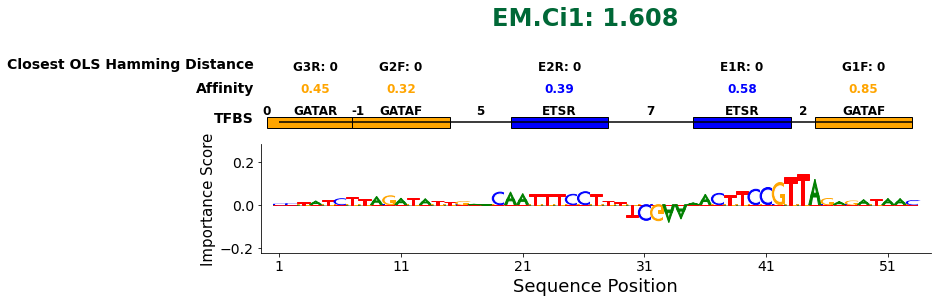

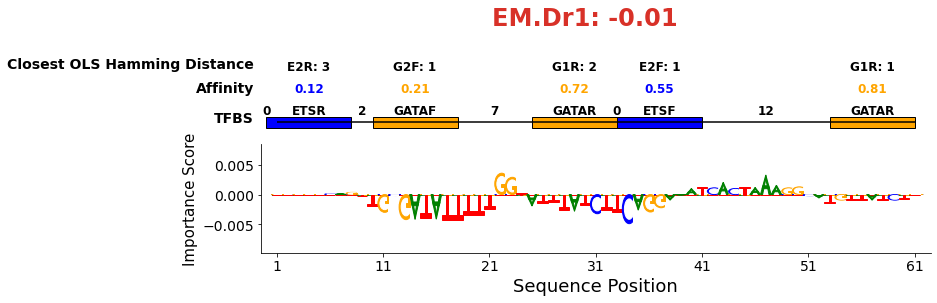

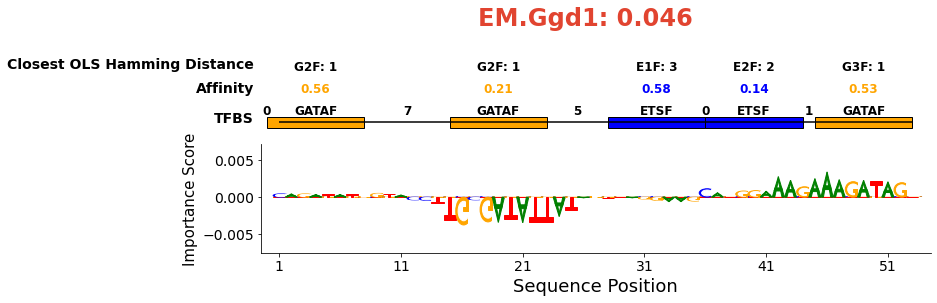

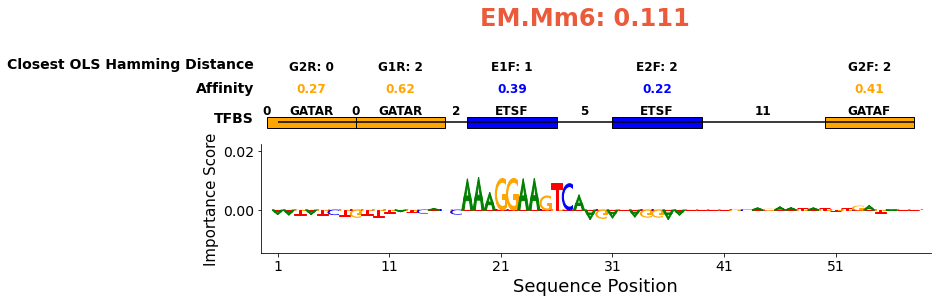

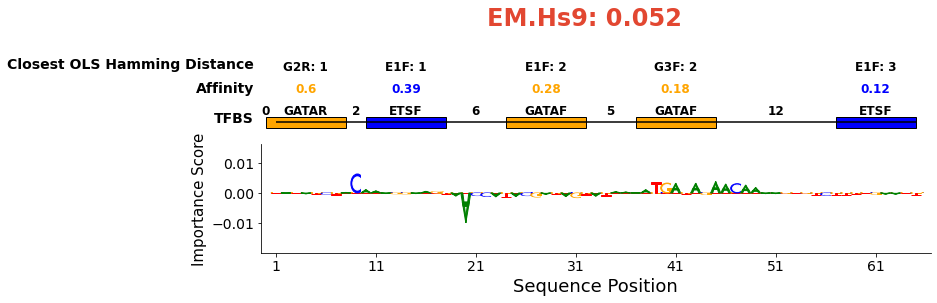

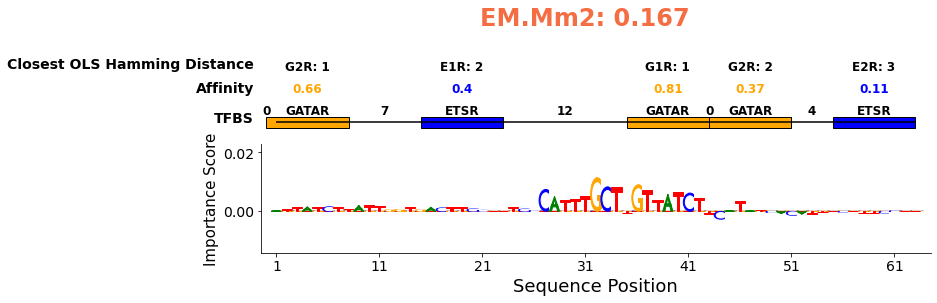

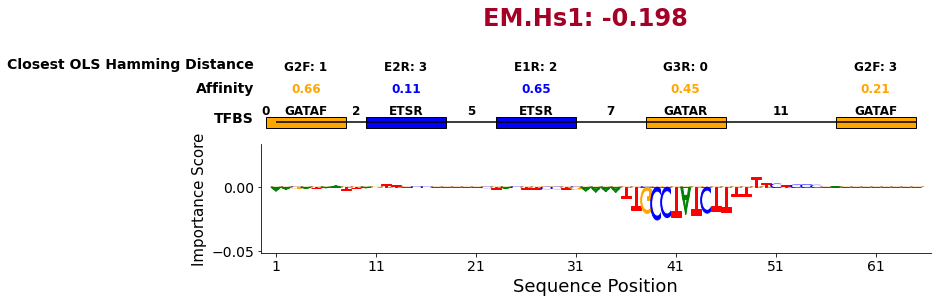

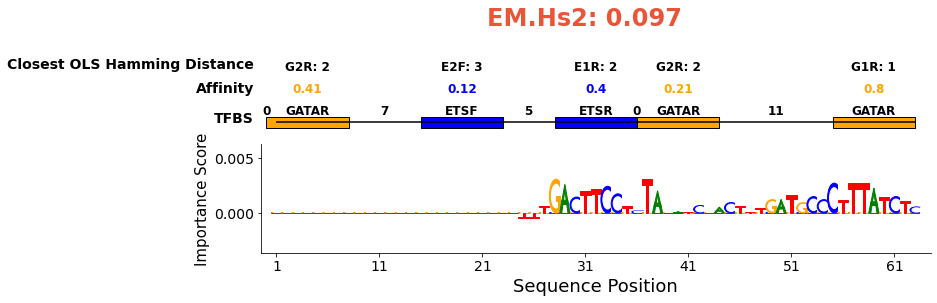

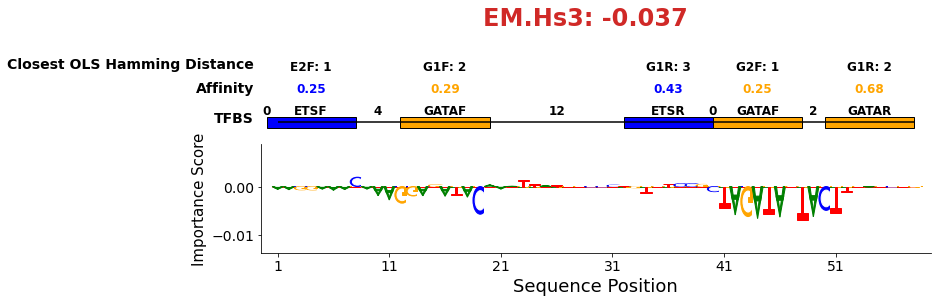

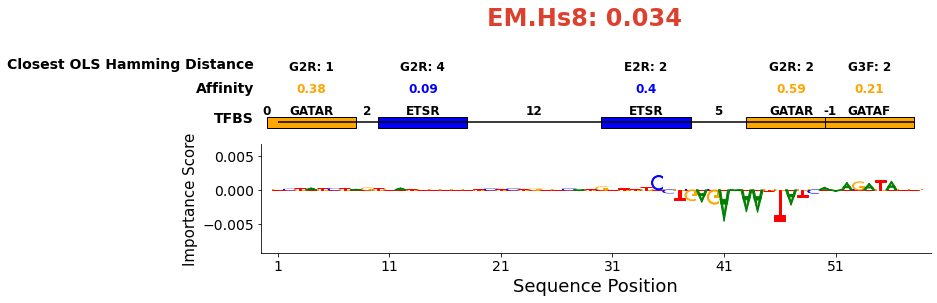

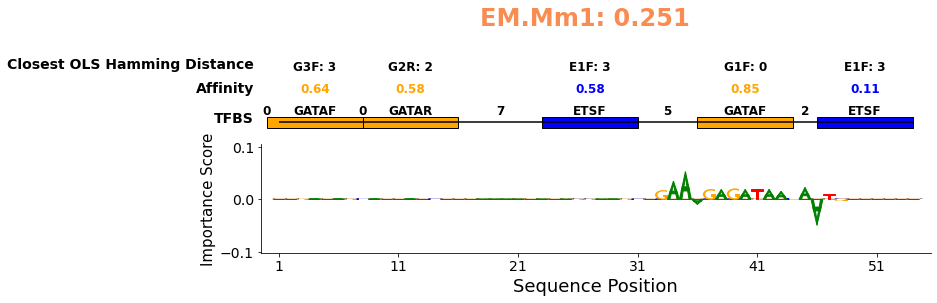

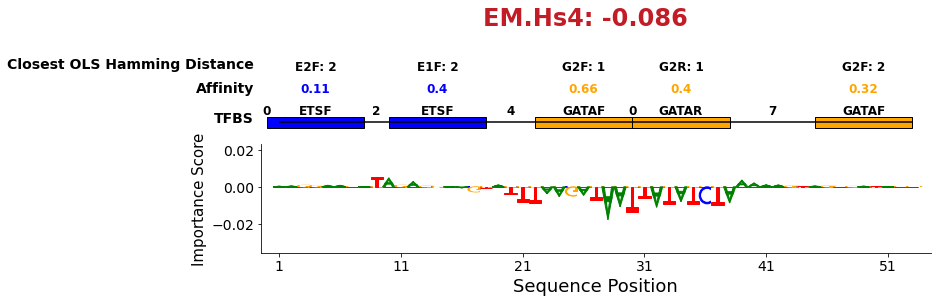

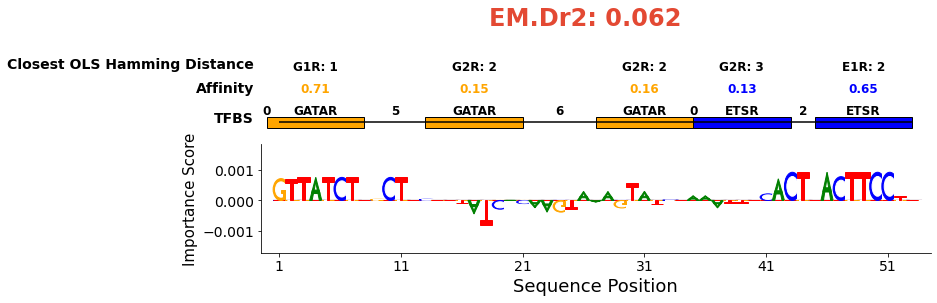

In [16]:
cmap = mpl.cm.RdYlGn
norm = mpl.colors.Normalize(vmin=test_clf["GKSVM_SCORE"].min(), vmax=test_clf["GKSVM_SCORE"].max())
for i in range(len(seqs)):
    otx_enhancer_utils.otxGenomeTracks(seqs[i], importance_scores=impscores[i], seq_name=test_clf["NAME"].iloc[i], model_pred=test_clf["GKSVM_SCORE"].iloc[i], cmap=cmap, norm=norm)

# Scratch

In [35]:
# Read in scores
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explain_f)
]
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(fasta_f))
              if i%2==1]
fasta_ids = [x.rstrip().replace(">", "") for (i,x) in enumerate(open(fasta_f))
              if i%2==0]
onehot_data = np.array([project_utils.one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])

<ipython-input-35-5b4fa84a834f>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  onehot_data = np.array([project_utils.one_hot_encode_along_channel_axis(x)


In [204]:
test_seq = test_clf.iloc[2]
test_seq

NAME                                                         EM.Ggd1
SEQ                CAGATATGGTACCTTGCGATATTATAGTCAGGAAGCATGGAAAGAA...
FXN_LABEL                                                          0
FXN_DESCRIPTION                                              No expr
TILE                                                            Full
SEQ_LEN                                                           53
GKSVM_SCORE                                                 0.045951
GKSVM_PREDS                                                        1
GKSVM_CLF                                                         FP
Name: 2, dtype: object

In [47]:
tfbs_data = otx_enhancer_utils.defineTFBS(test_seq["SEQ"])
tfbs_data

{2: ['GATA', 'R', 'CCTATCTT', 0.44555488676087596, 0, 'G3R', 'CCTATCTT', 0],
 9: ['GATA', 'F', 'TAGATATT', 0.32103457131865104, -1, 'G2F', 'AGATATT', 0],
 22: ['ETS', 'R', 'ATTTCCTT', 0.39163576347437207, 5, 'E2R', 'ATTTCCTT', 0],
 37: ['ETS', 'R', 'ACTTCCGT', 0.5819540373459362, 7, 'E1R', 'ACTTCCGT', 0],
 47: ['GATA', 'F', 'GAGATAAC', 0.8467717279226579, 2, 'G1F', 'GAGATAAC', 0]}

In [197]:
def otxGenomeTracks(seq):
    # Get the annotations for the seq
    tfbs_annot = otx_enhancer_utils.defineTFBS(seq)
    
    # Define subplots
    fig, ax = plt.subplots(2, 1, figsize=(12,4), sharex=True)
    plt.subplots_adjust(wspace=0, hspace=0)

    # Build the annotations in the first subplot
    h = 0.1  # height of TFBS rectangles
    ax[0].set_ylim(0, 1)  # lims of axis
    ax[0].spines['bottom'].set_visible(False)  #remove axis surrounding, makes it cleaner
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].tick_params(left = False)  #remove tick marks on y-axis
    ax[0].set_yticks([0.25, 0.525, 0.75])  # Add ticklabel positions
    ax[0].set_yticklabels(["TFBS", "Affinity", "Closest OLS Hamming Distance"], weight="bold")  # Add ticklabels
    ax[0].hlines(0.2, 1, len(seq), color="black")  #  Backbone to plot boxes on top of

    # Build rectangles for each TFBS into a dictionary
    tfbs_blocks = {}
    for pos in tfbs_annot.keys():
        if tfbs_annot[pos][0] == "GATA":
            tfbs_blocks[pos] = mpl.patches.Rectangle((pos-2, 0.2-(h/2)), width=8, height=h, facecolor="orange", edgecolor="black")
        elif tfbs_annot[pos][0] == "ETS":
            tfbs_blocks[pos] = mpl.patches.Rectangle((pos-2, 0.2-(h/2)), width=8, height=h, facecolor="blue", edgecolor="black")

    # Plot the TFBS with annotations, should be input into function
    for pos, r in tfbs_blocks.items():
        ax[0].add_artist(r)
        rx, ry = r.get_xy()
        ytop = ry + r.get_height()
        cx = rx + r.get_width()/2.0
        tfbs_site = tfbs_annot[pos][0] + tfbs_annot[pos][1]
        tfbs_aff = round(tfbs_annot[pos][3], 2)
        closest_match = tfbs_annot[pos][5] + ": " + str(tfbs_annot[pos][7])
        spacing = tfbs_annot[pos][4]
        ax[0].annotate(tfbs_site, (cx, ytop), color='black', weight='bold', 
                    fontsize=12, ha='center', va='bottom')
        ax[0].annotate(tfbs_aff, (cx, 0.45), color=r.get_facecolor(), weight='bold', 
                    fontsize=12, ha='center', va='bottom')
        ax[0].annotate(closest_match, (cx, 0.65), color="black", weight='bold', 
                    fontsize=12, ha='center', va='bottom')
        ax[0].annotate(str(spacing), (((rx-spacing) + rx)/2, 0.25), weight='bold', color="black", 
                fontsize=12, ha='center', va='bottom')

    # Plot the featue importance scores
    viz_sequence.plot_weights_given_ax(ax[1], impscores[0], subticks_frequency=10, height_padding_factor=1)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].set_xlabel("Sequence Position")
    ax[1].set_ylabel("Importance Score");

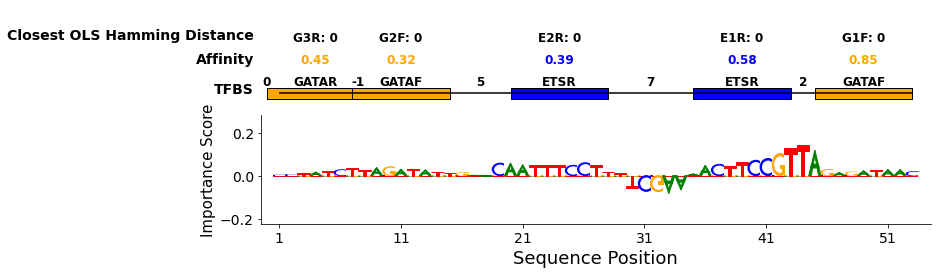

In [195]:
# Define subplots
fig, ax = plt.subplots(2, 1, figsize=(12,4), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)

# Build the annotations
h = 0.1  # height of TFBS rectangles
ax[0].set_ylim(0, 1)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(left = False)
ax[0].set_yticks([0.25, 0.525, 0.75])
ax[0].set_yticklabels(["TFBS", "Affinity", "Closest OLS Hamming Distance"], weight="bold")
ax[0].hlines(0.2, 1, test_seq["SEQ_LEN"], color="black")

# Build rectangles for each TFBS into a dictionary
tfbs_blocks = {}
for pos in tfbs_data.keys():
    if tfbs_data[pos][0] == "GATA":
        tfbs_blocks[pos] = mpl.patches.Rectangle((pos-2, 0.2-(h/2)), width=8, height=h, facecolor="orange", edgecolor="black")
    elif tfbs_data[pos][0] == "ETS":
        tfbs_blocks[pos] = mpl.patches.Rectangle((pos-2, 0.2-(h/2)), width=8, height=h, facecolor="blue", edgecolor="black")
        
# Plot the TFBS with annotations, should be input into function
for pos, r in tfbs_blocks.items():
    ax[0].add_artist(r)
    rx, ry = r.get_xy()
    ytop = ry + r.get_height()
    cx = rx + r.get_width()/2.0
    tfbs_site = tfbs_data[pos][0] + tfbs_data[pos][1]
    tfbs_aff = round(tfbs_data[pos][3], 2)
    closest_match = tfbs_data[pos][5] + ": " + str(tfbs_data[pos][7])
    spacing = tfbs_data[pos][4]
    ax[0].annotate(tfbs_site, (cx, ytop), color='black', weight='bold', 
                fontsize=12, ha='center', va='bottom')
    ax[0].annotate(tfbs_aff, (cx, 0.45), color=r.get_facecolor(), weight='bold', 
                fontsize=12, ha='center', va='bottom')
    ax[0].annotate(closest_match, (cx, 0.65), color="black", weight='bold', 
                fontsize=12, ha='center', va='bottom')
    ax[0].annotate(str(spacing), (((rx-spacing) + rx)/2, 0.25), weight='bold', color="black", 
            fontsize=12, ha='center', va='bottom')

# Plot the featue importance scores
viz_sequence.plot_weights_given_ax(ax[1], impscores[0], subticks_frequency=10, height_padding_factor=1)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel("Sequence Position")
ax[1].set_ylabel("Importance Score");